In [1]:
import json
from functools import partial
from race.codeeval.metrics_utils import *
import pandas as pd

In [ ]:
metrics_mapping = {
    'readability_name_camel': metrics_for_readability_camel,
    'readability_name_snake': metrics_for_readability_snake,
    'readability_length_setting_2': partial(metrics_for_readability_length, max_line_length=70, max_function_length=30),
    'readability_comment_by_line': metrics_for_readability_comment_by_line,
}


def output_readability(model, output_path_root):
    dims = [
        'readability_name_camel', 
        'readability_name_snake',  
        'readability_length_setting_2', 
        'readability_comment_by_line', 
    ]
    
    dataset = 'humaneval'
    

    generated_data_result_mapping = []

    for dim in dims:
        
        input_results_file = os.path.join(output_path_root, f'humaneval/{dataset}_{dim}_{model}_parsed_eval_results.json')
                        
        with open(input_results_file, 'r') as f:
            results = json.load(f)

        for key in results['eval'].keys():
            if key != 'correctness':
                pass_base_cnt = 0
                pass_plus_cnt = 0
                pass_if_cnt = 0
                pass_base_if_cnt = 0
                pass_plus_if_cnt = 0
                pass_if_not_base_cnt = 0
                pass_if_not_plus_cnt = 0
                pass_if_base_not_plus_cnt = 0
                pass_base_not_plus_cnt = 0
                pass_if_plus_base_cnt = 0
                
                num_samples = len(results['eval'][key])
                for i in range(num_samples):
                    if results['eval'][key][i]['base_status'] == 'pass' and metrics_mapping[dim](results['eval'][key][i]['solution']) and not results['eval'][key][i]['plus_status'] == 'pass':
                        pass_if_plus_base_cnt += 1
                        
                    if results['eval'][key][i]['base_status'] == 'pass':
                        pass_base_cnt += 1
                        
                    if results['eval'][key][i]['plus_status'] == 'pass':
                        pass_plus_cnt += 1
                        
                    if metrics_mapping[dim](results['eval'][key][i]['solution']):
                        pass_if_cnt += 1
                        
                    if results['eval'][key][i]['plus_status'] == 'pass' and metrics_mapping[dim](results['eval'][key][i]['solution']):
                        pass_plus_if_cnt += 1
                        
                    if results['eval'][key][i]['base_status'] == 'pass' and metrics_mapping[dim](results['eval'][key][i]['solution']):
                        pass_base_if_cnt += 1
                    
                    if results['eval'][key][i]['base_status'] == 'pass' and not results['eval'][key][i]['plus_status'] == 'pass':
                        pass_base_not_plus_cnt += 1
                        
                    if results['eval'][key][i]['base_status'] == 'pass' and not results['eval'][key][i]['plus_status'] == 'pass' and metrics_mapping[dim](results['eval'][key][i]['solution']):
                        pass_if_base_not_plus_cnt += 1
                  

                generated_data_result_mapping.append({
                    'model': model,
                    'dim': dim,
                    'key': key,
                    'pass_base_rate': pass_base_cnt / num_samples,
                    'pass_plus_rate': pass_plus_cnt / num_samples,
                    'pass_base_not_plus_rate': pass_base_not_plus_cnt / num_samples,
                    'pass_if_rate': pass_if_cnt / num_samples,
                    'pass_if_given_fluke': pass_if_base_not_plus_cnt / pass_base_not_plus_cnt if pass_base_not_plus_cnt > 0 else None,
                    'pass_if_given_base': pass_base_if_cnt / pass_base_cnt if pass_base_cnt > 0 else None,
                    'pass_if_given_plus': pass_plus_if_cnt / pass_plus_cnt if pass_plus_cnt > 0 else None,
                })
    
    return generated_data_result_mapping

In [8]:
models = [
    'gpt-4o',
    'gpt-35-turbo-16k',
    'Meta-Llama-3-1-8B-Instruct-nwxcg',
    'Meta-Llama-3-1-70B-Instruct-htzs',
    'Mistral-large-ygkys',
    'Mistral-small-zgjes',
]

In [9]:
data = []
for model in models:
    print(f"Processing {model}")
    data += output_readability(model, '../')
df = pd.DataFrame(data)

# Remove task ids with FNs as measured with evalplus data
fn = ['HumanEval/141',
 'HumanEval/20',
 'HumanEval/107',
 'HumanEval/9',
 'HumanEval/116',
 'HumanEval/114',
 'HumanEval/92',
 'HumanEval/6',
 'HumanEval/88',
 'HumanEval/142',
 'HumanEval/126',
 'HumanEval/136',
 'HumanEval/62',
 'HumanEval/83']

df = df[~df['key'].isin(fn)]

Processing gpt-4o
Processing gpt-35-turbo-16k
Processing Meta-Llama-3-1-8B-Instruct-nwxcg
Processing Meta-Llama-3-1-70B-Instruct-htzs
Processing Mistral-large-ygkys
Processing Mistral-small-zgjes


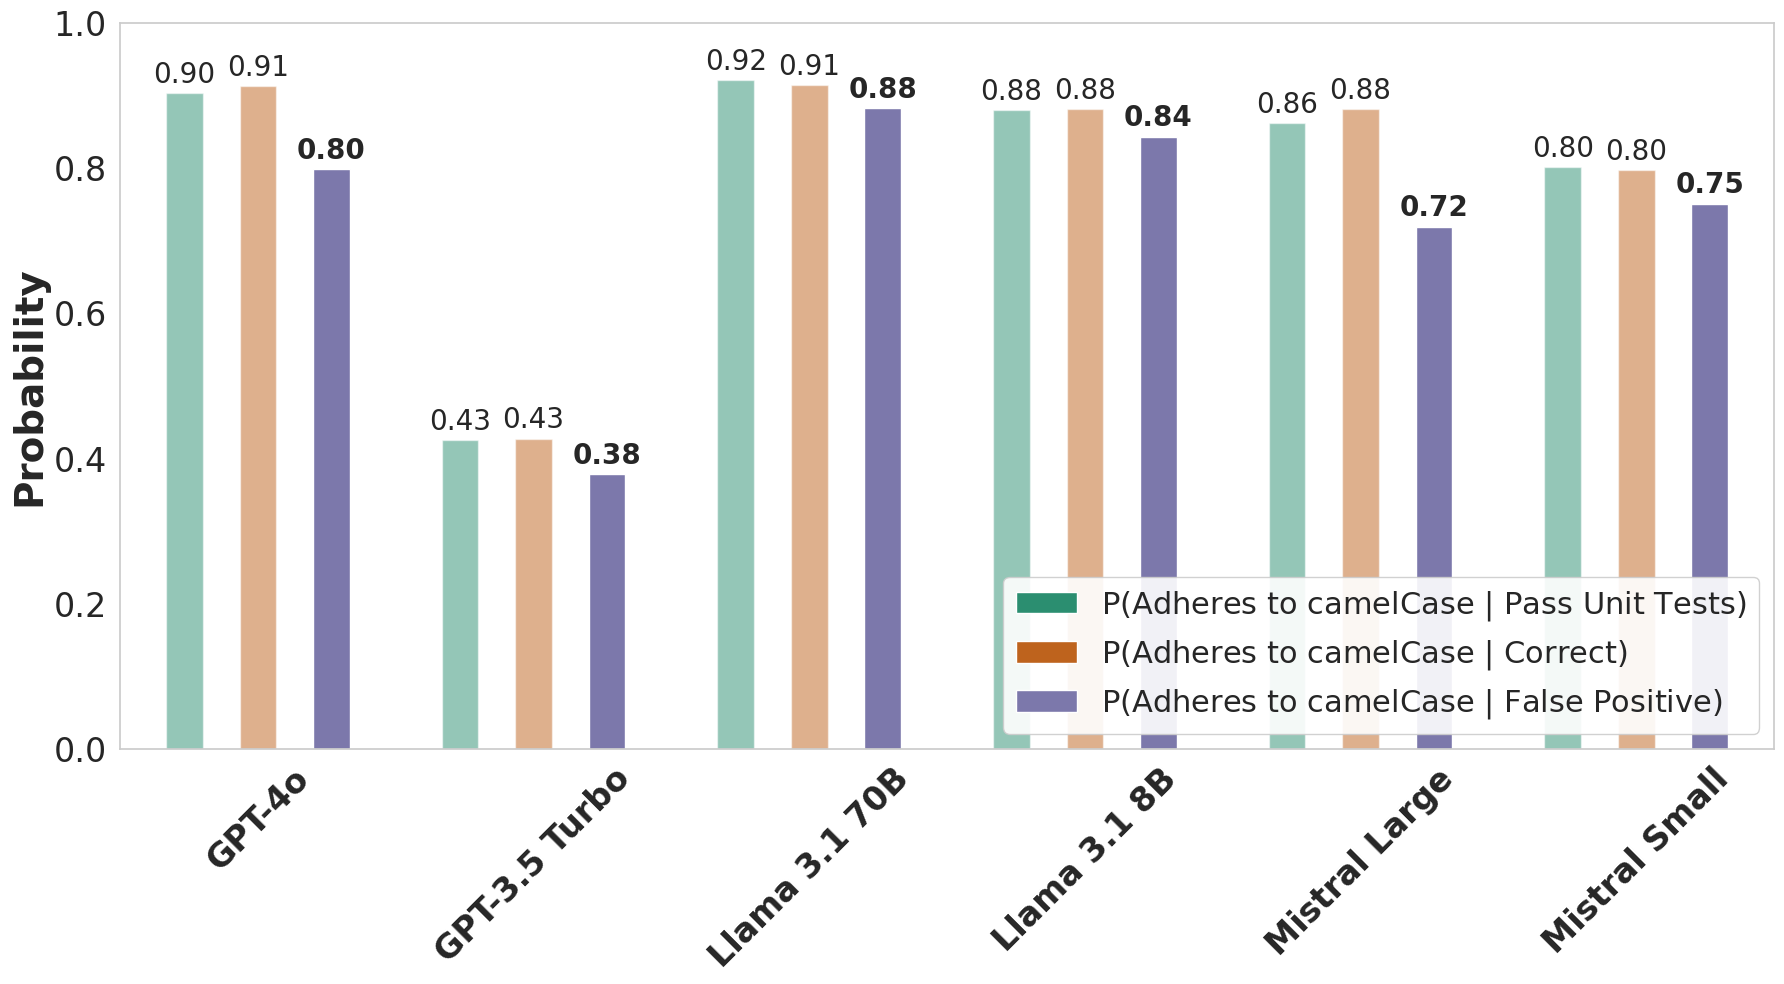

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')

# Melt the dataframe to long format
df_melted = df.melt(id_vars=['model', 'key', 'dim'], 
                    value_vars=['pass_if_given_base', 'pass_if_given_plus', 'pass_if_given_fluke'], 
                    var_name='metric', value_name='value')

# Replace metrics with more descriptive names
df_melted['metric'] = df_melted['metric'].replace({
    'pass_if_given_fluke': r'$\text{P}(\text{Adheres to camelCase } | \text{ False Positive})$',
    'pass_if_given_base': r'$\text{P}(\text{Adheres to camelCase } | \text{ Pass Unit Tests})$',
    'pass_if_given_plus': r'$\text{P}(\text{Adheres to camelCase } | \text{ Correct})$',
})

# rename models
df_melted['model'] = df_melted['model'].replace({
    'gpt-4o': 'GPT-4o',
    'gpt-35-turbo-16k': 'GPT-3.5 Turbo',
    'Meta-Llama-3-1-8B-Instruct-nwxcg': 'Llama 3.1 8B',
    'Meta-Llama-3-1-70B-Instruct-htzs': 'Llama 3.1 70B',
    'Mistral-large-ygkys': 'Mistral Large',
    'Mistral-small-zgjes': 'Mistral Small'
})

# Determine consistent model ordering based on the average values across all metrics
model_order = ['GPT-4o', 'GPT-3.5 Turbo', 'Llama 3.1 70B', 'Llama 3.1 8B', 'Mistral Large', 'Mistral Small']

# Set up the plot
plt.figure(figsize=(18, 10))

# Define color palette
color_palette = sns.color_palette("Dark2", 3)

# Filter for camelCase data only
camel_data = df_melted[df_melted['dim'] == 'readability_name_camel']

# Create the barplot
ax = sns.barplot(x='model', y='value', hue='metric', data=camel_data, errorbar=None,
                 order=model_order, palette=color_palette, width=0.8, gap=0.5)

# Customize the plot
ax.set_title('', fontsize=28, weight='bold')
ax.set_ylabel('Probability', fontsize=28 , weight='bold')
ax.set_xlabel('', fontsize=16)
ax.tick_params(axis='both', labelsize=24)
ax.tick_params(axis='x', rotation=45)

# make x lables bold
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

ax.set_ylim(0, 1)
ax.grid(False)

# Adjust legend and make background box less trasparent
ax.legend(title='', title_fontsize='12', fontsize=22, loc='lower right', framealpha=0.9)

# Add value labels on the bars
for i, container in enumerate(ax.containers):
    if i == 2:
        ax.bar_label(container, fmt='%.2f', padding=3, weight='bold', fontsize=20)
    else:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=20)
        for bar in container:
            bar.set_alpha(0.5)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

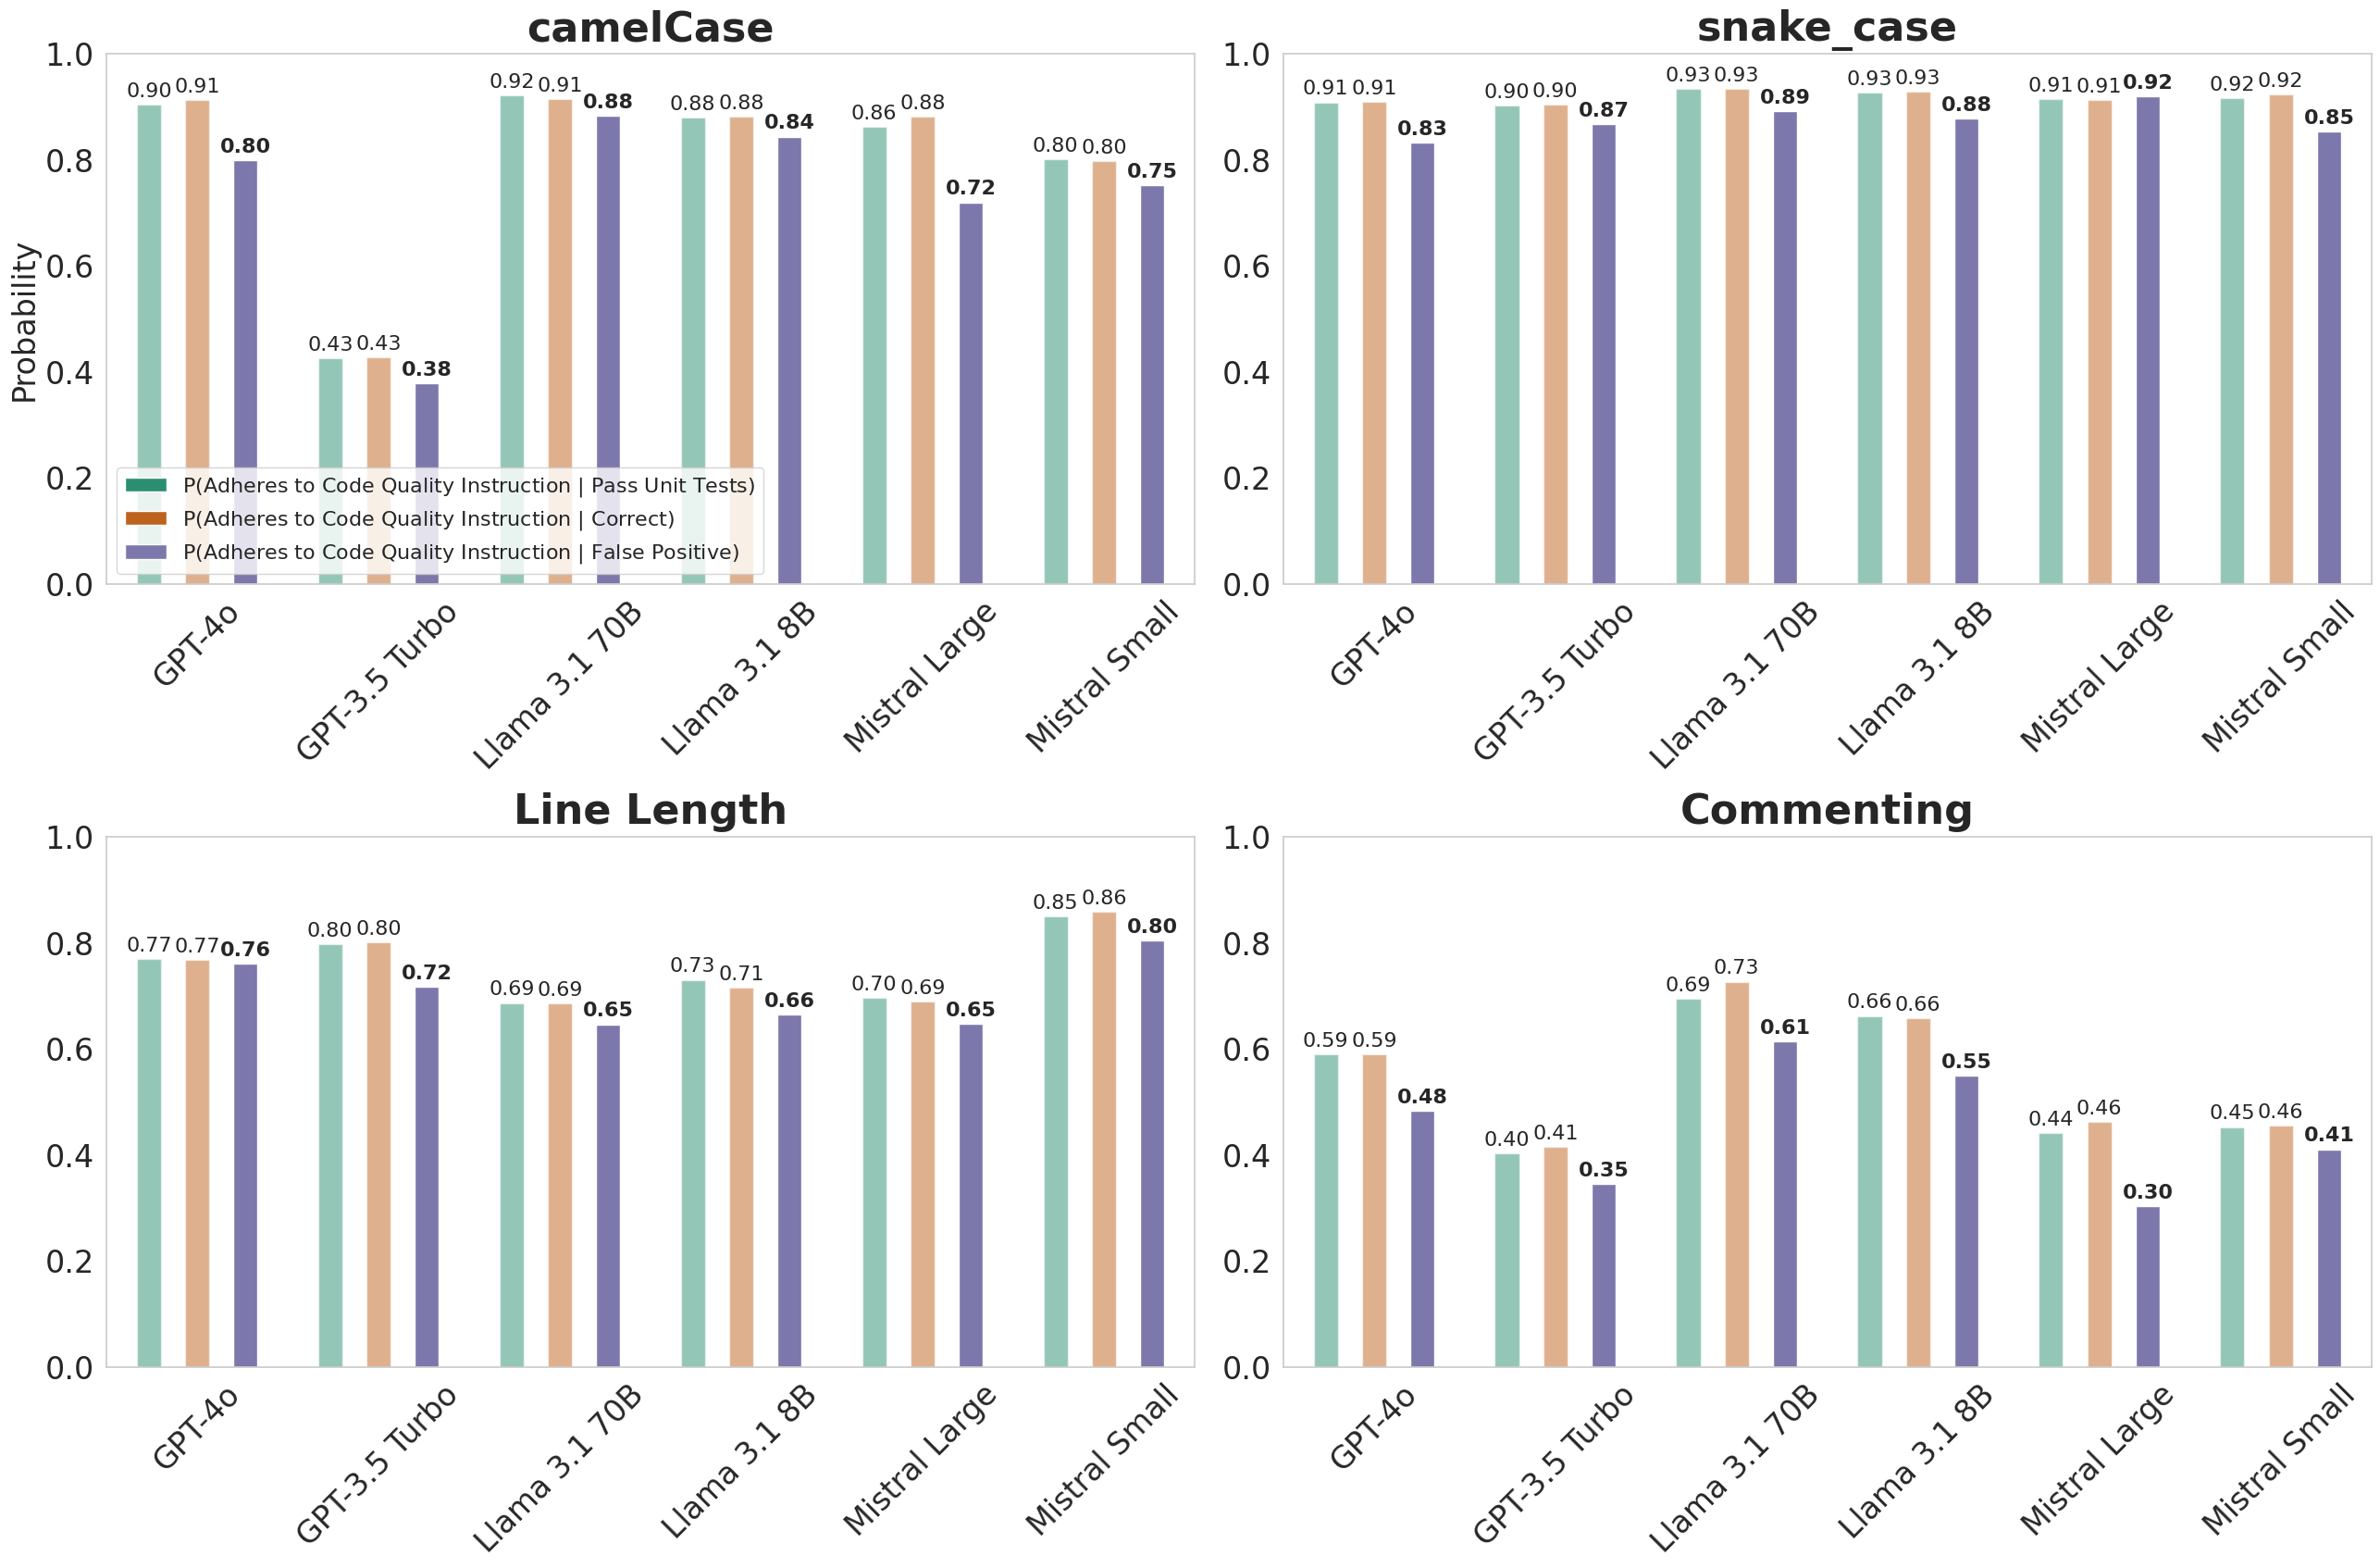

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')

# Melt the dataframe to long format
df_melted = df.melt(id_vars=['model', 'key', 'dim'], 
                    value_vars=['pass_if_given_base', 'pass_if_given_plus', 'pass_if_given_fluke'], 
                    var_name='metric', value_name='value')

# Replace metrics with more descriptive names
df_melted['metric'] = df_melted['metric'].replace({
    'pass_if_given_fluke': r'$\text{P}(\text{Adheres to Code Quality Instruction } | \text{ False Positive})$',
    'pass_if_given_base': r'$\text{P}(\text{Adheres to Code Quality Instruction } | \text{ Pass Unit Tests})$',
    'pass_if_given_plus': r'$\text{P}(\text{Adheres to Code Quality Instruction } | \text{ Correct})$',
})


# rename models
df_melted['model'] = df_melted['model'].replace({
    'gpt-4o': 'GPT-4o',
    'gpt-35-turbo-16k': 'GPT-3.5 Turbo',
    'Meta-Llama-3-1-8B-Instruct-nwxcg': 'Llama 3.1 8B',
    'Meta-Llama-3-1-70B-Instruct-htzs': 'Llama 3.1 70B',
    'Mistral-large-ygkys': 'Mistral Large',
    'Mistral-small-zgjes': 'Mistral Small'
})


# Determine consistent model ordering based on the average values across all metrics
model_order = ['GPT-4o', 'GPT-3.5 Turbo', 'Llama 3.1 70B', 'Llama 3.1 8B', 'Mistral Large', 'Mistral Small']

# Set up the plot with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(26, 18))
axes = axes.flatten()  # Flatten the 2x2 array for easier indexing

# Define color palette
color_palette = sns.color_palette("Dark2", 3)

# Create a barplot for each dimension
for i, dim in enumerate(df_melted['dim'].unique()):
    dim_data = df_melted[df_melted['dim'] == dim]

    # Create the barplot with consistent model ordering
    ax = sns.barplot(x='model', y='value', hue='metric', data=dim_data, errorbar=None,
                     order=model_order, palette=color_palette, ax=axes[i], width=0.8, gap=0.5)

    dim_renames = {
        'readability_name_camel': 'camelCase',
        'readability_name_snake': 'snake_case',
        'readability_length_setting_2': 'Line Length',
        'readability_comment_by_line': 'Commenting'
    }

    # Customize the plot
    ax.set_title(f'{dim_renames[dim]}', fontsize=32, weight='bold', pad=10)
    ax.set_ylabel('Probability', fontsize=24)
    ax.set_xlabel('', fontsize=16)
    ax.tick_params(axis='both', labelsize=24)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1)
    ax.grid(False)
    
    # Adjust legend
    if i == 0:  # Show legend only once
        ax.legend(title='', title_fontsize='12', fontsize=16, loc='lower left')
    else:
        ax.get_legend().remove()
        ax.set_ylabel('')

    # Add value labels on the bars
    for i, container in enumerate(ax.containers):
        if i == 2:
            ax.bar_label(container, fmt='%.2f', padding=3, weight='bold', fontsize=16)
            
        else:
            ax.bar_label(container, fmt='%.2f', padding=3, fontsize=16)
            for bar in container:
                bar.set_alpha(0.5)


# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to accommodate the shared x-axis label
plt.show()
